# Project 3: Web APIs & NLP

__By: Gregory Rankel__

## Problem Statement 

I currently work in the marketing department of the MLS and as part of our new expansion plan into Europe, we are looking to roll out a new marketing campaign by searching through peoples social media post and hashtags as a means growing the popularity of the MLS. In Europe however, Football means both Soccer and American Football due to the increasing expansion of the NFL overseas. Can I building a predictive model using the NFL and football reddit's to distinguish which type of football people are talking about and reach out to the ones interested in watching football?

We will run various classification models during our testing such as Bayes classifier, Logestic Regression, KNN, and CART's. To score these, we will be looking at Accuracy as a means of scoring and determining which model we will be selecting here. 

## Executive Summary:

When being tasked with this project, I had to go out on our own and find two different subreddit pages: one that talked about Football and one that talked about American Football. Browsing through the football community for a page to use, I was able to settle upon the football subreddit on one page that we would be able to pull information. When it came to finding the American Football subreddit, I was unable to use their page due to the inappropriate language that I was reading through when it came to the titles. I then decided it would be best to use the NFL page as a means of me gathering my data. From there, we were able to pull the information through the API that subreddit has to offer and extract the text we were looking for in a concatenated Data Frame (df).

After creating our df, we then had to start our cleaning process of dropping unnecessary columns as well as cleaning up our text. We started by dropping columns that had unnecessary features as well as any duplicates that were in the dataset. This then brought us to 6 columns that I believe can add value to our dataset. After lowering, splitting, and Porter Stemming our Dataset, we then had a Data set that was ready to be analyzed. We looked at most common words through our Count Vectorizer and which words were important in our Tfidf Vectorizer. After gaging what words stood out, we were ready to run our models and evaluate the data given.

## Table of Contents

- [1.4. Loading Libraries & Data](#Loading_Libraries_&_Data)
- [1.5. Data Dictionary ](#Data_Dictionary)
- [1.6. Preliminary EDA](#Preliminary-EDA)
- [1.7. Data Cleaning](#Data-Cleaning)
- [1.8. Exploratory Data Analysis (EDA)](#Exploratory_Data_Analysis_(EDA))
- [1.9. Model Preperation](#Model_Preperation)
- [1.10. Modeling](#Modeling)
- [1.11. Model Selection](#Model_Selection)
- [1.12. Model Evaluation](#Model_Evaluation)
- [1.13. Conclusion](#Conclusion)
- [1.14. Recommendations](#Recommendations)
- [1.15. References](#References)

## Loading Libraries & Data

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.collocations import ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
import regex as re
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB, GaussianNB,  BernoulliNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [5]:
df = pd.read_csv('scrapped_df.csv', index_col= 0)

## Data Dictionary 

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**title**|*Object*|Final Data Frame|Comment in post being made| 
|**selftext**|*Object*|Final Data Frame|Text that doesn't link outside of reddit|
|**subreddit**|*Object*|Final Data Frame|Community within reddit|
|**author**|*Object*|Final Data Frame|Person who is publishing post within subreddit|
|**num_comments**|*Integer*|Final Data Frame|How many comments the post gathered.|
|**timestamp**|*Object*|Final Data Frame|Date of the post|
|**clean_title**|*Object*|Final Data Frame|Title words after being cleaned and Porter Stemmed|


## Preliminary EDA

For Preliminary EDA, I just wanted to get a basic overview of the data being brought in from the API and gage the columns that we have. We wanted to see any statstics and null values on the data and see if anything stuck out. 

In [6]:
df.head()

,title,selftext,subreddit,author,num_comments,timestamp
0,Who is free to help out with a sacko punishment?,Amazon gift card in it for yall haha\n\nwe hav...,nfl,spicyboy2727,13,2020-01-12
3,TIL The President of the NFL Hall of Fame is a...,[removed],nfl,No_Cat_No_Cradle,0,2020-01-12
6,The Browns are like the rich kid who got all t...,NaN,nfl,RuneSlayer4421,3,2020-01-12
7,"14 years later, Norv Turner's prediction of Ji...",During Troy Aikman's Hall of Fame enshrinement...,nfl,DraymondShldntWear23,3,2020-01-12
9,Is Jadeveon Clowney the dirtiest player in the...,After another dirty play from him today and th...,nfl,MikeG1990,21,2020-01-12


In [7]:
df.shape

(4692, 6)

In [8]:
df.describe()

,num_comments
count,4692.000000
mean,79.693947
std,622.109322
min,0.000000
25%,0.000000
50%,5.000000
75%,29.000000
max,28192.000000


In [9]:
df.dtypes

title           object
selftext        object
subreddit       object
author          object
num_comments     int64
timestamp       object
dtype: object

In [10]:
df.isnull().sum()

title             0
selftext        581
subreddit         0
author            0
num_comments      0
timestamp         0
dtype: int64

## Data Cleaning

For Data Cleaning, several steps were taken within the data gathering notebook such as dropping unecessary columns and duplicates from our data. Please see it github link to binder. We first filled in all the null values within the 'selftext' column as 'empty' to signify nothing was inputted for that columns. We then decided to use Porter Stemmer as a means of cleaning the words within the reddits because with the Porter Stemmer method, it is a little more particular in words in looking for words that are possibly mispelled so with the vast amount of words the it will be searching for, itll be able to look through all the text and return the base of the word. To do this though, we can only have lower case text and numbers so we had to remove all grammer punctuations from the text. Finally we mapped our subreddit columns to our positive and negative values with the NFL being our negative value of 0 and Football being our positive value of 1.

In [11]:
df.fillna('none', inplace = True)

In [12]:
df.isnull().sum()

title           0
selftext        0
subreddit       0
author          0
num_comments    0
timestamp       0
dtype: int64

In [13]:
 p_stemmer =PorterStemmer()

In [14]:
def title_to_words(raw_title):
    #read through and pull only letters
    letters_only = re.sub("[^a-zA-Z0-9]", " ", raw_title )
    #split words and lowercase
    words = letters_only.lower().split()
    #convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    #Remove stopwords.
    important_words = [w for w in words if w not in stops]
    #Porter Stemmer the important words and return the base
    stem = [p_stemmer.stem(word) for word in important_words]
    #Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(important_words))

In [15]:
# Initialize an empty list to hold the clean reviews.
total_title = df.shape[0]
clean_title = []

print("Cleaning and parsing the title...")

# Instantiate counter.
j = 0

# For every review in our training set...
for title in df['title']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_title .append(title_to_words(title))
    
     # If the index is divisible by 500, print a message.
    if (j + 1) % 500 == 0:
        print(f'Review {j + 1} of {total_title}.')
    
    j += 1

Cleaning and parsing the title...
Review 500 of 4692.
Review 1000 of 4692.
Review 1500 of 4692.
Review 2000 of 4692.
Review 2500 of 4692.
Review 3000 of 4692.
Review 3500 of 4692.
Review 4000 of 4692.
Review 4500 of 4692.


In [16]:
#add cleaned words to dataframe
df['clean_title'] = clean_title

In [17]:
df.head()

,title,selftext,subreddit,author,num_comments,timestamp,clean_title
0,Who is free to help out with a sacko punishment?,Amazon gift card in it for yall haha\n\nwe hav...,nfl,spicyboy2727,13,2020-01-12,free help sacko punishment
3,TIL The President of the NFL Hall of Fame is a...,[removed],nfl,No_Cat_No_Cradle,0,2020-01-12,til president nfl hall fame convicted forger
6,The Browns are like the rich kid who got all t...,none,nfl,RuneSlayer4421,3,2020-01-12,browns like rich kid got cool toys never knew use
7,"14 years later, Norv Turner's prediction of Ji...",During Troy Aikman's Hall of Fame enshrinement...,nfl,DraymondShldntWear23,3,2020-01-12,14 years later norv turner prediction jimmy jo...
9,Is Jadeveon Clowney the dirtiest player in the...,After another dirty play from him today and th...,nfl,MikeG1990,21,2020-01-12,jadeveon clowney dirtiest player nfl


In [18]:
#will convert nfl text to 1 and football text to 0
df['subreddit'].unique()

array(['nfl', 'football'], dtype=object)

In [19]:
df['subreddit'] = df['subreddit'].map({'nfl' : 0, 'football' : 1})

In [20]:
df['subreddit'].unique()


array([0, 1])

## Exploratory Data Analysis (EDA)

For our EDA, I wanted to get the most frequent word counts that were being used within the data so I ran a count Vectorizer and a Tfidf Vectorizer on n-grams of (1,2) to see if there is a word or words that stuck out. We found that majority of the most frequent words were the same however, the word 'happy' showed up in the Tfidf Vectorizer. This tells me that the word is very important within a doc of a corpus so further reserch needs to be done on that.

In [21]:
cvec = CountVectorizer(ngram_range=(1,2))

We will first look at the count of certain words were being shown at through our CountVectorizer (in 1 and 2 word grams) and graph our findings within a bar chart.

In [22]:
df.head()

,title,selftext,subreddit,author,num_comments,timestamp,clean_title
0,Who is free to help out with a sacko punishment?,Amazon gift card in it for yall haha\n\nwe hav...,0,spicyboy2727,13,2020-01-12,free help sacko punishment
3,TIL The President of the NFL Hall of Fame is a...,[removed],0,No_Cat_No_Cradle,0,2020-01-12,til president nfl hall fame convicted forger
6,The Browns are like the rich kid who got all t...,none,0,RuneSlayer4421,3,2020-01-12,browns like rich kid got cool toys never knew use
7,"14 years later, Norv Turner's prediction of Ji...",During Troy Aikman's Hall of Fame enshrinement...,0,DraymondShldntWear23,3,2020-01-12,14 years later norv turner prediction jimmy jo...
9,Is Jadeveon Clowney the dirtiest player in the...,After another dirty play from him today and th...,0,MikeG1990,21,2020-01-12,jadeveon clowney dirtiest player nfl


In [23]:
X_text = cvec.fit_transform(df['clean_title'])

In [24]:
X_text_df = pd.DataFrame(X_text.toarray(),
                        columns = cvec.get_feature_names())

In [25]:
X_text_df.head(10)

,00,00 dead,00 entry,00 pm,000,000 000,000 beckham,000 career,000 clearing,000 dead,...,zlatan ibrahimovic,zone,zone ball,zone offense,zone question,zone soft,zone vs,zones,zrebiec,zrebiec harbaugh
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
top_word = X_text_df.sum().sort_values(0,ascending = False).head(10)
top_word

nfl         524
football    416
team        403
game        355
would       270
season      269
league      254
vs          231
best        189
player      183
dtype: int64

We want to take the top ten words here shown per our CountVec visualize findings on a graph

In [27]:
label = list(top_word)

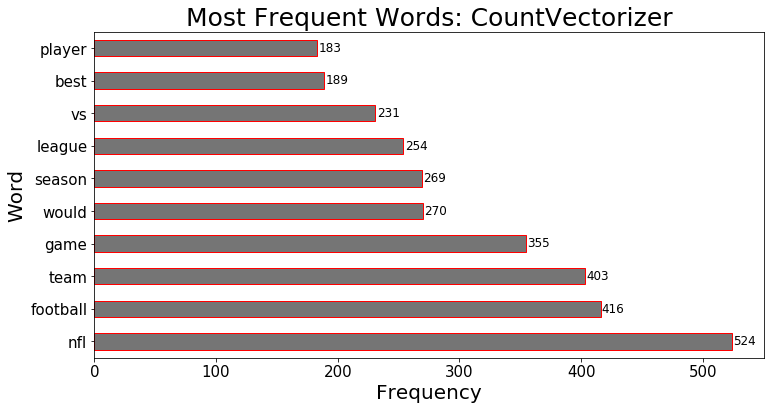

In [28]:
plt.figure(figsize=(12,6))
top_word.sort_values(ascending = False).plot(kind = 'barh', color=(0.1, 0.1, 0.1, 0.6), edgecolor='red')
plt.title('Most Frequent Words: CountVectorizer',size = 25)
plt.xlabel('Frequency',size = 20)
plt.ylabel('Word',size = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
r = list(range(1,11))
for i in range(0,len(r)):
    plt.text(x = top_word.sort_values(ascending = False)[i]+1 , y = r[i]-1.1, s = label[i], size = 12)


When analyzing the graph, we notice that more generic words within sports were the ones that came up the most with football, team, game etc. being within the top 5. Sport specific words also were shown which would help us distinguish the two such as nfl being the most frequency word relating more to american football and league which tends to be more used in european football.

In [29]:
tvec = TfidfVectorizer(ngram_range=(1,2))

We will now take a look at the frequency that the word were being shown at through our TfidfVectorizer (in 1 and 2 word grams) and graph our findings within a bar chart.

In [30]:
X_text_tvec = tvec.fit_transform(df['clean_title'])

In [31]:
X_text_tvec_df = pd.DataFrame(X_text_tvec.toarray(),
                        columns = tvec.get_feature_names())

In [32]:
X_text_tvec_df.head(10)

,00,00 dead,00 entry,00 pm,000,000 000,000 beckham,000 career,000 clearing,000 dead,...,zlatan ibrahimovic,zone,zone ball,zone offense,zone question,zone soft,zone vs,zones,zrebiec,zrebiec harbaugh
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
top_word_tvec = X_text_tvec_df.sum().sort_values(ascending = False).head(10)
top_word_tvec

football    69.187295
nfl         65.678704
happy       65.214297
team        54.329795
game        46.944567
league      36.275903
season      36.079234
best        34.528178
vs          34.139525
would       33.648031
dtype: float64

We want to take the top ten words here shown per our TVec visualize findings on a graph

In [34]:
label_1 = list(X_text_tvec_df.sum().sort_values(ascending = False).head(10))
label_tvec = [round(i,2) for i in label_1]

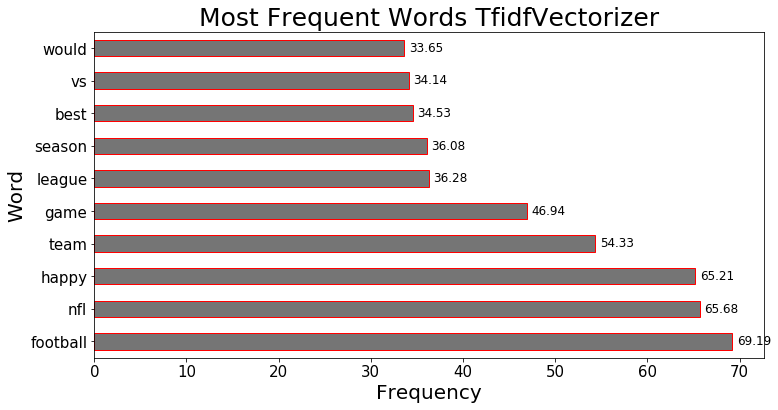

In [35]:
plt.figure(figsize=(12,6))
top_word_tvec.sort_values(ascending = False).plot(kind = 'barh', color=(0.1, 0.1, 0.1, 0.6), edgecolor='red')
plt.title('Most Frequent Words TfidfVectorizer',size = 25)
plt.xlabel('Frequency',size = 20)
plt.ylabel('Word',size = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
r = list(range(1,11))
for i in range(len(r)):
    plt.text(x = top_word_tvec.sort_values(ascending = False)[i]+.5, y = r[i]-1.1, s = label_tvec[i], size = 12)
    

Similar to the countvectorizer, majority of the words tend to pop up the same here as well. One word however, that stuck out more was the word 'happy'. This was something that I did not expect to see here and will be intereted to see how this word gets evaluated within our models and which side itll lean towards. 

With all the information gathered and shown, I believe that there will be enough information to help us distinguish the two types of football and that we would be able to create a successful model to show that.



## Model Preparation

For Modeling Preperation, we just wanted to set our X value and Target Value (y) to our data set. Based on the question we are trying to solve, we deemed that the X variable we will be exploring is the 'clean_title' while the Target variable we are trying to solve will be 'subreddit'.

In [36]:
target = df['subreddit']
X = df['clean_title']
y = target

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 14, test_size = 0.33, stratify = y)


## Modeling

For all our models, we will be using FeaturedUnion with Count Vectorizer and Tfidf Vectorizer . By doing this, it will combine the best features being used for both CountVectorizer and TfidfVectorizer create a complex model that I believe will score better rather then running the Count Vectorizer and Tfidf Vectorizer seperately. When selecting our features within the model, it was a lot of trial an error when selecting features to best suited across all our models. Results shown below show best model fitted based on the features run. 


Several Model types we will be evaluating are:
- Logistic Regression
- KNN
- Multinominal Naive Bayes
- Bernoulli Naive Bayes
- Decision Trees

After running Train/Test Scores, we ran a cross validation score across the entire data set as a means of verifying scores can be relied upon. 

__Baseline Model__

Our baseline model is the percent of the most frequent class between both options. In this situation, NFL is more frequent so that will use that to determine the baseline model.

In [38]:
df['subreddit'].value_counts()

0    2859
1    1833
Name: subreddit, dtype: int64

In [39]:
df['subreddit'].value_counts(normalize = True)

0    0.609335
1    0.390665
Name: subreddit, dtype: float64

What setting up a baseline model does for us is that it gives us a score to beat and a metric that we can use to compare when models are created. If we were to see model scores being below 60%, this would show us that our model is not doing a great job and serious changes need to be made to it. With our score being 60% this shows the percentage of subreddits are related to american football and the other 40% being related to European Football.

__Model 1: Feature Union and Logistic Regression__
When feature selecting 

In [40]:
pipe_log = Pipeline(steps = [('feats', FeatureUnion([
    ('cvec', CountVectorizer()),
    ('tvec', TfidfVectorizer())])),
    ('lr', LogisticRegression(solver = 'liblinear')),
])


In [41]:
pipe_params_log = {
    'feats__cvec__max_features': [4500],
    'feats__cvec__ngram_range': [(1, 1)],
    'feats__cvec__stop_words' : ['english'],
    'feats__tvec__max_features': [3500],
    'feats__tvec__ngram_range': [(2,2)],
    'feats__tvec__stop_words' : ['english'],
    'lr__penalty': ['l2'],
    'lr__C' : [2]
}

In [42]:
#gridsearch over all parameters
pipe_log_gridsearch = GridSearchCV(pipe_log,
                                pipe_params_log ,
                                cv = 5,
                                scoring='accuracy',
                                verbose=1)

In [43]:
#fit data
pipe_log_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


In [44]:
#search for best score on fitted data
pipe_log_gridsearch.best_params_

{'feats__cvec__max_features': 4500,
 'feats__cvec__ngram_range': (1, 1),
 'feats__cvec__stop_words': 'english',
 'feats__tvec__max_features': 3500,
 'feats__tvec__ngram_range': (2, 2),
 'feats__tvec__stop_words': 'english',
 'lr__C': 2,
 'lr__penalty': 'l2'}

In [45]:
# search for best score on fitted data
pipe_log_gridsearch.best_score_


0.8803690741329939

In [46]:
#confirms our scores are valid
cross_val_score(pipe_log_gridsearch.best_estimator_, X, target, cv= 5).mean()

0.8631765271303117

In [47]:
train_score = pipe_log_gridsearch.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = pipe_log_gridsearch.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.8804
Best TEST set accuracy: 0.8806


__Model 2: FeatureUnion + KNeighbors__

In [48]:
pipe_knn = Pipeline(steps = [('feats', FeatureUnion([
    ('cvec', CountVectorizer()),
    ('tvec', TfidfVectorizer())])),
    ('sc', StandardScaler(with_mean=False)),                         
    ('knn', KNeighborsClassifier())
])


In [49]:
pipe_params_knn = {
    'feats__cvec__max_features': [1000],
    'feats__cvec__ngram_range': [(1, 2)],
    'feats__cvec__stop_words' : ['english'],
    'feats__tvec__max_features': [1000],
    'feats__tvec__ngram_range': [(2,2)],
    'feats__tvec__stop_words' : ['english'],
    'knn__n_neighbors':[1],
    'knn__metric':['euclidean']
}

In [50]:
pipe_knn_gridsearch = GridSearchCV(pipe_knn,
                                pipe_params_knn ,
                                cv = 5,
                                scoring='accuracy',
                                verbose=1)

In [51]:
#fit data
pipe_knn_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


In [52]:
#search for best score on fitted data
pipe_knn_gridsearch.best_params_

{'feats__cvec__max_features': 1000,
 'feats__cvec__ngram_range': (1, 2),
 'feats__cvec__stop_words': 'english',
 'feats__tvec__max_features': 1000,
 'feats__tvec__ngram_range': (2, 2),
 'feats__tvec__stop_words': 'english',
 'knn__metric': 'euclidean',
 'knn__n_neighbors': 1}

In [53]:
train_score = pipe_knn_gridsearch.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = pipe_knn_gridsearch.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.7700
Best TEST set accuracy: 0.7508


In [54]:
cross_val_score(pipe_knn_gridsearch.best_estimator_, X, target, cv= 5).mean()

0.7267651763913385

__Model 3: Feature Union and Multinominal Naive Bayes__

In [55]:
pipe_mnb = Pipeline(steps = [('feats', FeatureUnion([
    ('cvec', CountVectorizer()),
    ('tvec', TfidfVectorizer())])),
                            
    ('mnb', MultinomialNB())
])

In [56]:
pipe_params_mnb = {
    'feats__cvec__max_features': [3000],
    'feats__cvec__ngram_range': [(1, 2)],
    'feats__cvec__stop_words' : ['english'],
    'feats__tvec__max_features': [4000],
    'feats__tvec__ngram_range': [(1, 1)],
    'feats__tvec__stop_words' : ['english']
}

In [57]:
pipe_mnb_gridsearch = GridSearchCV(pipe_mnb,
                                pipe_params_mnb ,
                                cv = 5,
                                scoring='accuracy',
                                verbose=1)

In [58]:
pipe_mnb_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feats',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('cvec',
                                                                        CountVectorizer(analyzer='word',
                                                                                        binary=False,
                                                                                        decode_error='strict',
                                                                                        dtype=<class 'numpy.int64'>,
                                                                                        encoding='utf-8',
                                                                                        input='content',
                                                              

In [59]:
pipe_mnb_gridsearch.best_params_

{'feats__cvec__max_features': 3000,
 'feats__cvec__ngram_range': (1, 2),
 'feats__cvec__stop_words': 'english',
 'feats__tvec__max_features': 4000,
 'feats__tvec__ngram_range': (1, 1),
 'feats__tvec__stop_words': 'english'}

In [60]:
train_score = pipe_mnb_gridsearch.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = pipe_mnb_gridsearch.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.8692
Best TEST set accuracy: 0.8825


In [61]:
cross_val_score(pipe_mnb_gridsearch.best_estimator_, X, target, cv= 5).mean()

0.8657317588839938

__Model 4: FeaturedUnion and Bernoulli Naive Bayes__

In [62]:
pipe_bnb = Pipeline(steps = [('feats', FeatureUnion([
    ('cvec', CountVectorizer()),
    ('tvec', TfidfVectorizer())])),
                            
    ('mnb', BernoulliNB())
])

In [63]:
pipe_params_bnb = {
    'feats__cvec__max_features': [3000],
    'feats__cvec__ngram_range': [(1, 2)],
    'feats__cvec__stop_words' : ['english'],
    'feats__tvec__max_features': [4000],
    'feats__tvec__ngram_range': [(1,2)],
    'feats__tvec__stop_words' : ['english']
}

In [64]:
pipe_bnb_gridsearch = GridSearchCV(pipe_bnb,
                                pipe_params_bnb ,
                                cv = 5,
                                scoring='accuracy',
                                verbose=1)

In [65]:
pipe_bnb_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feats',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('cvec',
                                                                        CountVectorizer(analyzer='word',
                                                                                        binary=False,
                                                                                        decode_error='strict',
                                                                                        dtype=<class 'numpy.int64'>,
                                                                                        encoding='utf-8',
                                                                                        input='content',
                                                              

In [66]:
pipe_bnb_gridsearch.best_params_

{'feats__cvec__max_features': 3000,
 'feats__cvec__ngram_range': (1, 2),
 'feats__cvec__stop_words': 'english',
 'feats__tvec__max_features': 4000,
 'feats__tvec__ngram_range': (1, 2),
 'feats__tvec__stop_words': 'english'}

In [67]:
train_score = pipe_bnb_gridsearch.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = pipe_bnb_gridsearch.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.8801
Best TEST set accuracy: 0.8851


In [68]:
cross_val_score(pipe_bnb_gridsearch.best_estimator_, X, target, cv= 5).mean()

0.8606206199799162

__Model 5: FeaturedUnion and Decision Tree__

In [69]:
pipe_dt = Pipeline(steps = [('feats', FeatureUnion([
    ('cvec', CountVectorizer()),
    ('tvec', TfidfVectorizer())])),
                            
    ('dt', DecisionTreeClassifier(random_state = 14))
])

In [70]:
pipe_params_dt  = {
    'feats__cvec__max_features': [3000, 5000],
    'feats__cvec__ngram_range': [(1, 2), (2,2)],
    'feats__cvec__stop_words' : ['english'],
    'feats__tvec__max_features': [3000, 5000],
    'feats__tvec__ngram_range': [(1, 1), (1,2)],
    'feats__tvec__stop_words' : ['english'],
    'dt__max_depth' : [10],
    'dt__min_samples_split' : [5],
    'dt__min_samples_leaf' : [1]
}

In [71]:
pipe_dt_gridsearch = GridSearchCV(pipe_dt,
                                pipe_params_dt ,
                                cv = 5,
                                scoring='accuracy',
                                verbose=1)

In [72]:
pipe_dt_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   29.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feats',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('cvec',
                                                                        CountVectorizer(analyzer='word',
                                                                                        binary=False,
                                                                                        decode_error='strict',
                                                                                        dtype=<class 'numpy.int64'>,
                                                                                        encoding='utf-8',
                                                                                        input='content',
                                                              

In [73]:
pipe_dt_gridsearch.best_params_

{'dt__max_depth': 10,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 5,
 'feats__cvec__max_features': 5000,
 'feats__cvec__ngram_range': (2, 2),
 'feats__cvec__stop_words': 'english',
 'feats__tvec__max_features': 5000,
 'feats__tvec__ngram_range': (1, 1),
 'feats__tvec__stop_words': 'english'}

In [74]:
train_score = pipe_dt_gridsearch.best_score_
print('Best TRAIN set accuracy: {:.4f}'.format(train_score))
test_score = pipe_dt_gridsearch.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.7528
Best TEST set accuracy: 0.7424


In [75]:
cross_val_score(pipe_dt_gridsearch.best_estimator_, X, target, cv= 5).mean()

0.7425454915007164

## Model Selection

For model selection, we went with FeaturedUnion with Logistic as when running our models, it scored the best on both train and test, had high bias and low variance. Below well create a dataframe to show the scores of all the models.

In [76]:
score_df = pd.DataFrame(columns = ['Model', 'Train Score', 'Test Score'])

In [77]:
score_df['Model'] = ['Logistic Regression', 'KNN', 'Multinominal Naive Bayes', 'Bernoulli Naive Bayes', 'Decision Tree']

In [78]:
score_df['Train Score'] = [pipe_log_gridsearch.best_score_,pipe_knn_gridsearch.best_score_, pipe_mnb_gridsearch.best_score_,
                     pipe_bnb_gridsearch.best_score_, pipe_dt_gridsearch.best_score_]

In [79]:
score_df['Train Score'] = [round(x,4) for x in score_df['Train Score']]

In [80]:
score_df['Test Score'] = [pipe_log_gridsearch.score(X_test, y_test),pipe_knn_gridsearch.score(X_test, y_test), pipe_mnb_gridsearch.score(X_test, y_test),
                     pipe_bnb_gridsearch.score(X_test, y_test), pipe_dt_gridsearch.score(X_test, y_test)]

In [81]:
score_df['Test Score'] = [round(x,4) for x in score_df['Test Score']]

In [82]:
score_df['Variance'] = score_df['Test Score'] - score_df['Train Score']

In [83]:
score_df

,Model,Train Score,Test Score,Variance
0,Logistic Regression,0.8804,0.8806,0.0002
1,KNN,0.7700,0.7508,-0.0192
2,Multinominal Naive Bayes,0.8692,0.8825,0.0133
3,Bernoulli Naive Bayes,0.8801,0.8851,0.0050
4,Decision Tree,0.7528,0.7424,-0.0104


## Model Evaluation 

When evaluating our model, we wanted to get a look at the 

In [84]:
#get predicitons based on our model selection
log_preds = pipe_log_gridsearch.predict(X_test)

In [85]:
pipe_log_gridsearch.best_estimator_.steps[1][1].coef_[0]

array([ 0.12775364,  0.47119306, -0.11916086, ...,  0.03157297,
       -0.13274772, -0.39410404])

In [86]:
best_features = pipe_log_gridsearch.best_estimator_.named_steps['feats'].get_feature_names()
print(len(best_features))

8000


In [87]:
parent_type = ['tvec'if 'tvec' in x else 'cvec' for x in best_features]

In [88]:
print(len(parent_type))

8000


We will now look to pull the coeffients from our model and produce a top ten chart for words that lean more towards european football and words that lean more towards american football

In [89]:
#get coefficients
coef = pipe_log_gridsearch.best_estimator_.steps[1][1].coef_[0]

In [90]:
#create dataframe of coef
df_coef = pd.DataFrame({'coef' : coef, 'parent_type' : parent_type, 'feature_name' : best_features})

In [91]:
#get top ten coef from nfl
nfl = df_coef.sort_values(by = 'coef', ascending = False).head(10).set_index('feature_name')['coef']

In [92]:
#get top ten coef from football
football = df_coef.sort_values(by = 'coef', ascending = True).head(10).set_index('feature_name')['coef']

In [93]:
#concatenate football and nfl
df_coef = pd.concat([football, nfl],sort = False)

In [94]:
df_coef = pd.DataFrame(df_coef)

In [95]:
#get featured name as column in dataframe
df_coef['feature_names'] = df_coef.index

In [96]:
df_coef.sort_values(by = 'coef', ascending = False).head()

,coef,feature_names
feature_name,,
cvec__happy,3.034262,cvec__happy
cvec__match,2.214295,cvec__match
cvec__world,2.123472,cvec__world
cvec__ucl,2.117543,cvec__ucl
cvec__messi,2.061793,cvec__messi


In [97]:
df_coef.sort_values(by = 'coef', ascending = False).tail()

,coef,feature_names
feature_name,,
cvec__quarterbacks,-1.720278,cvec__quarterbacks
cvec__games,-1.792571,cvec__games
cvec__patriots,-1.905643,cvec__patriots
cvec__week,-2.051027,cvec__week
cvec__nfl,-3.789992,cvec__nfl


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text yticklabel objects>)

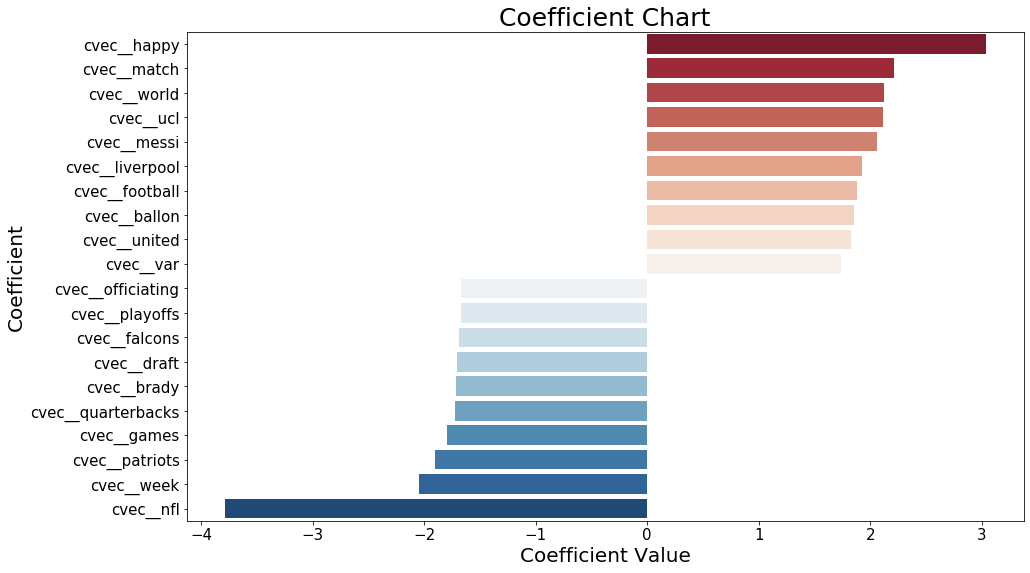

In [98]:
plt.figure(figsize=(15,9))
sns.barplot( data =df_coef.sort_values(by = 'coef', ascending = False), y = 'feature_names',
            x ='coef',palette='RdBu')
plt.title("Coefficient Chart", size = 25)
plt.xlabel('Coefficient Value',size = 20)
plt.ylabel('Coefficient',size = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

After getting a look at our coeffiecnt chart, it was very interesting to see the highest coefficient word that tend to lean towards european soccer was happy. With a coefficient of ~3.03, you were almost 20.7 time as likely to be talking about european football rather than american football. All other words that we noticed really made sence to have higher coefficients seeing that 'match', 'world', 'ucl' are all regonized within eurpean soccer circles while'patriots', quarter_backs, 'nfl' are all well known words within american football.

__Create Confustion Matrix__

In [99]:
def pretty_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = y_true.unique()
    labels.sort()
    
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10,4))
    sns.heatmap(cm, annot=True, fmt='g', cmap="Reds",xticklabels=labels, yticklabels=labels)
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')

In [100]:
# Generate confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test,
                                  log_preds).ravel()

print(confusion_matrix(y_test,
                       log_preds))

[[863  81]
 [104 501]]


In [101]:
# Accuracy Calc

acc = (tp+ tn)/(tp+fn+tn+fp)

print(f'Accuracy: {round(acc, 4)}')

Accuracy: 0.8806


In [102]:
#Missclassification Calc

miss = 1 - acc

print(f'Missclassification: {round(miss, 4)}')

Missclassification: 0.1194


In [103]:
# Sensitivity Calc

sens = tp/(tp+fn)

print(f'Sensitivity: {round(sens, 4)}')

Sensitivity: 0.8281


In [104]:
# Specificity Calc

spec = tn/(tn+fp)

print(f'Specificity: {round(spec, 4)}')

Specificity: 0.9142


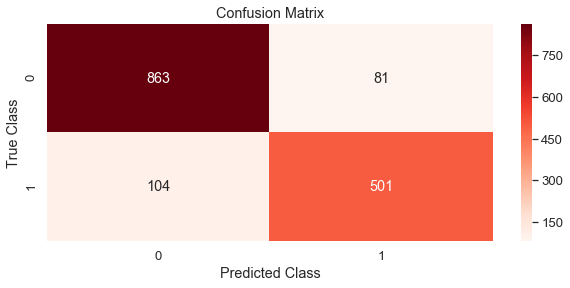

In [105]:
pretty_confusion_matrix(y_test,log_preds)

Our confusion matrix above shows how well our words are being classified. Words that are locatede in the bottom right (also our True Positives) show how well our model is at evaluating words that are talking about euuropean football are also shown that they are being predicted to talk about european football while onthe oppsoite end of the chart (True Negatives) show words that are talking about american football are also being predicted to talk about american football.

__Create Histogram of Football and NFL (0 and 1) as another means of visualizing confusion matriz__

In [106]:
def df_pred(model):
    pred_proba = [i[1] for i in model.predict_proba(X_test)]

    pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
    return pred_df

In [107]:
 pred_df = df_pred(pipe_log_gridsearch)

In [108]:
pred_df.head()

,true_values,pred_probs
111,0,0.187342
408,0,0.007902
414,0,0.547448
290,1,0.910634
177,0,0.036080


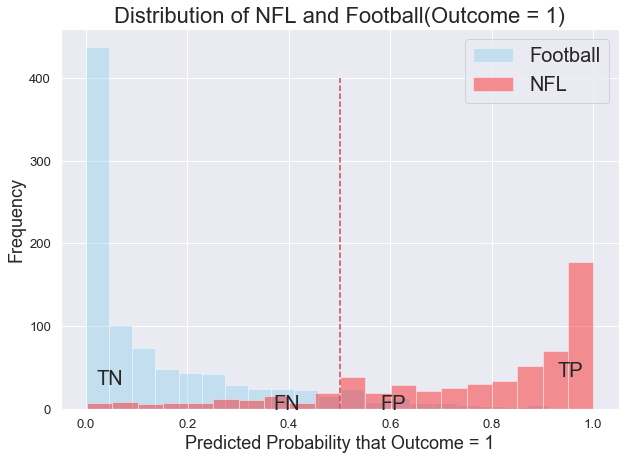

In [109]:
plt.figure(figsize = (10,7))


sns.distplot(pred_df[pred_df['true_values'] ==0]['pred_probs'],
             color="skyblue", 
             label="True Values", 
             hist = True,
             bins = 20,
             kde = False,)
sns.distplot(pred_df[pred_df['true_values'] == 1]['pred_probs'], 
             color="red", 
             label="Sepal Width", 
             hist = True, 
             bins = 20,
             kde = False)

plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)
plt.title('Distribution of NFL and Football(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18) 

plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 400,
           color = 'r',
           linestyle = '--')

plt.annotate(xy = (0.02, 30),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.37, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.58, 0),
             s = 'FP',
             size = 20)

plt.annotate(xy = (0.93, 40),
             s = 'TP',
             size = 20)


L =plt.legend(fontsize = 20)
L.get_texts()[0].set_text('Football')
L.get_texts()[1].set_text('NFL')

Our histogram about visually shows how well our words are being seperated as we are looking for seperation of our two distributions. The minimal overlap shows that there arent many words that the model cant distinguish between which type of football is being talked about. This is a postive graph to see when we want to evaluating just so we know our model is performing very well.

__ROC Curve__

For our ROC Curve, we wanted to see how close our curve was to 1 signifying the words are easily seperable

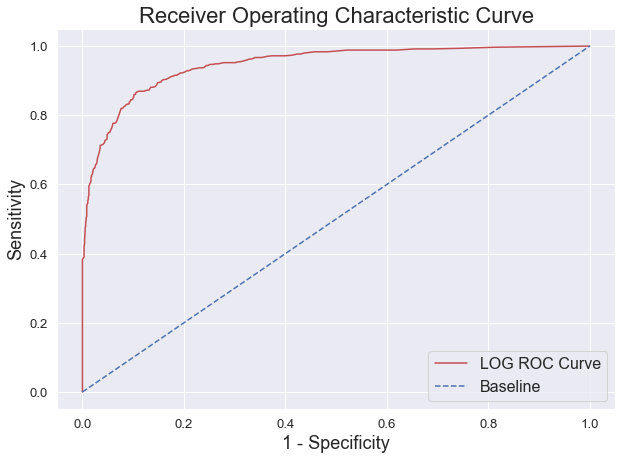

In [110]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate SENSITIVITY. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - SPECIFICITY. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]



# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='LOG ROC Curve',
        color = 'r')


# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='Baseline',
         linestyle='--')

# Create legend.
plt.legend(fontsize=16);

In [111]:
#ROC Score
roc_auc_score(pred_df['true_values'],
             pred_df ['pred_probs'])

0.946572524163048

If you have an ROC AUC of 1, your positive and negative populations are perfectly separated and your model and this is a perfect model. Our ROC AUC of .946 indicates that our postive and negative populations are 94.6% seperated by our logistic regression model. Our goal with deploying a model is to build a model that has no overlap between the red and blue histograms shown on our probability distribution. The ROC AUC curve illustrates the amount of overlap that exists between our distribution.

## Conclusion

In conclusion, we can say that we were able to build a good model based on key words being used in both reddits. We were able to show a high bias train score along with a very low variance when evaluating that against our test. As we look at our coefficients, we we were able to see several words that, when exponentiated, will tell us how many times likely a word is to appear in that subreddit. When looking at the top ten for each, words you would expect to associate with each sport were there but he most interesting find from this was the word 'happy'. Happy had a coefficient of ~3.03, and when exponentiated, we found out that people using the word happy will be 20.7 times as likely to be talking about football rather then the NFL. When evaluating our Confusion Matrix, several key stats stood out to us:
- Accuracy: 
    88.1%
- Misclassification:
    11.9%
- Sensitivity:
	82.8%
- Specificity:
	91.5%

With these measurements, we can see how accurately our prediction were against the model we built. We can say we were 88% accurate in predicting the words that went into both the NFL and Football bucket where we misclassified ~12% of them. We can also state that our True positive which represent the words that were actually correlated to football subreddits and they predicted to be part of the football subreddits, scored at a 82.8% accuracy based on all the predicted values that predicted to be in the football subreddit.


## Recommendations

Going forward, the model will fairly predict well and can be implemented to score at a high rate. However, based on the fact that we were only able to pull an estimated 4,700 data points, I don't believe we are ready to roll out this model yet. I would like to first analyze the selftext column that we pulled to see if there are possibly some key words in there that can be pulled. I also believe we should keep searching for various other blogs/ post to see if the same words keep popping up and cross validate those against each other. Once we gain confidence on the key words being used in social media post to see which type of football people are talking about, then we can roll out our model to market. 